## Imports

In [1]:
import os
import glob
import cv2
import random
import numpy as np 
import pandas as pd
from  PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
import warnings
from catboost import CatBoostClassifier
import math
import joblib
warnings.filterwarnings("ignore")

## Functions

In [2]:
def get_images_labels(data_path, resize=False):
    """Reads the images from the data path and returns the images and labels as numpy arrays

    Args:
        data_path (str): The path to the images
        resize (bool): Whether to resize the images or not

    Returns:
        images: np.array: The images as a numpy array
        labels: np.array: The labels as a numpy array
    """
    images = []
    labels = []
    for image_path in sorted(glob.glob(os.path.join(data_path, "*.jpg"))):
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if resize:
            image = cv2.resize(image, (500, 500), interpolation=cv2.INTER_CUBIC)
        images.append(image)
        labels.append(image_path.split("\\")[-1])
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

def visualise_images(images, labels):
    """
    Visualise the images in a grid format
    Args:
        images (np.array): Images as a numpy array
        labels (np.array): Labels as a numpy array
    
    Returns:
        None
    """
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    for i in range(5):
        axes[i].imshow(images[i])
        axes[i].set_title(labels[i])
        axes[i].axis('off')
    plt.show()

def hair_removal(image: np.ndarray, structuring_element_size: int = 15) -> np.ndarray:
    """
    Remove hair-like structures from an image using morphological operations and inpainting.
    
    Args:
        image (np.ndarray): Input color image
        structuring_element_size (int): Size of the structuring elements for morphological operations
    
    Returns:
        np.ndarray: Image with hair-like structures removed
    """
    # Convert the original image to grayscale if it has > 1 channel
    if len(image.shape) == 3:
        grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        grayscale = image

    # Create structuring elements for morphological filtering
    plus_shaped_se = cv2.getStructuringElement(1, (structuring_element_size, structuring_element_size))
    x_shaped_se = np.array(list(reversed(list(zip(*np.eye(structuring_element_size)))))) + np.eye(structuring_element_size)
    x_shaped_se[int(structuring_element_size/2), int(structuring_element_size/2)] = 1

    # Perform blackHat filtering on the grayscale image to find hair-like structures
    blackhat_plus = cv2.morphologyEx(grayscale, cv2.MORPH_BLACKHAT, plus_shaped_se)
    blackhat_x = cv2.morphologyEx(grayscale, cv2.MORPH_BLACKHAT, x_shaped_se.astype(np.uint8))
    combined_blackhat = blackhat_plus + blackhat_x

    # Create a binary mask of detected structures
    _, binary_mask = cv2.threshold(combined_blackhat, 10, 255, cv2.THRESH_BINARY)

    # Inpaint the original image using the binary mask
    inpainted_image = cv2.inpaint(image, binary_mask, 1, cv2.INPAINT_TELEA)

    return inpainted_image
    
def crop_img(img, threshold=100):
    """
    Crop the image to get the region of interest. Remove the vignette frame.
    Analyze the value of the pixels in the diagonal of the image, from 0,0 to h,w and
    take the points where this value crosses the threshold by the first time and for last.
    Args:
    - img (numpy ndarray): Image to crop.
    - threshold (int)    : Value to split the diagonal into image and frame.
    Return:
    - The coordinates of the rectangle and the cropped image.
    """
    # Get the image dimensions
    h, w = img.shape[:2]
    cd = math.gcd(h, w)  # Greatest Common Divider

    # Get the coordinates of the pixels in the diagonal
    y_coords = ([i for i in range(0, h, int(h/cd))], [i for i in range(h - int(h/cd), 0, -int(h/cd))])
    x_coords = ([i for i in range(0, w, int(w/cd))], [i for i in range(0, w, int(w/cd))])

    # Get the mean value of the pixels in the diagonal, form 0,0 to h,w 
    # and from h,0 to 0,w
    coordinates = {'y1_1': 0, 'x1_1': 0, 'y2_1': h, 'x2_1': w, 'y1_2': h, 'x1_2': 0, 'y2_2': 0, 'x2_2': w}
    for i in range(2):
        d = []
        y1_aux, x1_aux = 0, 0
        y2_aux, x2_aux = h, w 
        for y, x in zip(y_coords[i], x_coords[i]):
            d.append(np.mean(img[y, x, :]))

        # Get the location of the first point where the threshold is crossed
        for idx, value in enumerate(d):
            if (value >= threshold and idx != 0):  # If there's no vignette, in idx=0 the value would be > thresh..
                coordinates['y1_' + str(i + 1)] = y_coords[i][idx]
                coordinates['x1_' + str(i + 1)] = x_coords[i][idx]
                break

        # Get the location of the last point where the threshold is crossed
        for idx, value in enumerate(reversed(d)):
            if (value >= threshold and idx != 0):  # If there's no vignette, in idx=0 the value would be > thresh..
                coordinates['y2_' + str(i + 1)] = y_coords[i][len(y_coords[i])-idx]
                coordinates['x2_' + str(i + 1)] = x_coords[i][len(x_coords[i])-idx]
                break

    # Set the coordinates to crop the image
    y1 = max(coordinates['y1_1'], coordinates['y2_2'])
    y2 = min(coordinates['y2_1'], coordinates['y1_2'])
    x1 = max(coordinates['x1_1'], coordinates['x1_2'])
    x2 = min(coordinates['x2_1'], coordinates['x2_2'])

    img_new = img[y1:y2, x1:x2, :]

    if img_new.shape[0] == 0 or img_new.shape[1] == 0:
      img_new = img 
    
    return img_new

def normalize_colors_shades_of_gray(image: np.ndarray, norm_degree: int = 6, gamma_correction: float = None):
    """
    Normalize the colors of an image using the Shades of Gray algorithm with optional gamma correction.

    Parameters:
    - image (np.ndarray): The original image array in the format (height, width, channels).
    - norm_degree (int): The degree of the norm used for normalization, typically 6 as per the reference paper.
    - gamma_correction (float): Gamma correction value, typically 2.2 as per the reference paper, if None, no gamma correction is applied.

    Returns:
    - np.ndarray: The color-normalized image.
    """
    original_dtype = image.dtype  # Save original data type of image for later conversion

    if gamma_correction is not None:
        # Apply gamma correction
        image = image.astype('uint8')  # Convert image to uint8 for processing
        gamma_lookup_table = np.array([255 * (i / 255) ** (1 / gamma_correction) for i in range(256)], dtype='uint8').reshape(256, 1)
        image = cv2.LUT(image, gamma_lookup_table)  # Apply the lookup table

    # Convert image to float32 for normalization calculations
    image = image.astype('float32')

    # Calculate powers of the image's color channels and the mean across spatial dimensions
    channel_powers = np.power(image, norm_degree)
    mean_powers = np.power(np.mean(channel_powers, axis=(0, 1)), 1 / norm_degree)

    # Normalize the channel vectors
    norm_factor = np.sqrt(np.sum(np.square(mean_powers)))
    normalization_vector = mean_powers / norm_factor
    normalization_vector = 1 / (normalization_vector * np.sqrt(3))

    # Apply the normalization vector to the original image
    normalized_image = image * normalization_vector

    # Clip values to maintain image integrity and convert back to original data type
    normalized_image = np.clip(normalized_image, 0, 255).astype(original_dtype)

    return normalized_image

def enhance_structures(image):
    """Enhance the structures in an image using the unsharp masking technique. It is used to enhance the edges and details in an image. 
    Args:
        image (np.array): Image as a numpy array

    Returns:
        image: np.array: The image with the hair removed
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=1)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=1)
    image[binary == 255] = 255
    return image

def glcm_feature_extractor(image):
    """GLCM is a 2D matrix that is used to capture the spatial relationship between pixels in an image. It is used to capture the texture information of an image.
        It first gets the matrix of co-occurrence of pixel intensity pairs at a distance d = 1 [left, right, up, down] and angle theta = 0 (which is horizontal i.e 
        left to right). Then it calculates different statistics {contrast, correlation, energy and homogeneity} from the GLCM. It is calculated for different 
        distances and angles. 

    Args:
        image: Image as a numpy array

    Returns:
        features: List: A list containing the GLCM features
    """
    img = image
    GLCM = graycomatrix(img, [1], [0])       
    GLCM_Energy = graycoprops(GLCM, 'energy')[0]
    GLCM_corr = graycoprops(GLCM, 'correlation')[0]   
    GLCM_diss = graycoprops(GLCM, 'dissimilarity')[0]     
    GLCM_hom = graycoprops(GLCM, 'homogeneity')[0]    
    GLCM_contr = graycoprops(GLCM, 'contrast')[0]


    GLCM2 = graycomatrix(img, [3], [0])       
    GLCM_Energy2 = graycoprops(GLCM2, 'energy')[0]
    GLCM_corr2 = graycoprops(GLCM2, 'correlation')[0]      
    GLCM_diss2 = graycoprops(GLCM2, 'dissimilarity')[0]       
    GLCM_hom2 = graycoprops(GLCM2, 'homogeneity')[0]      
    GLCM_contr2 = graycoprops(GLCM2, 'contrast')[0]

    GLCM3 = graycomatrix(img, [5], [0])       
    GLCM_Energy3 = graycoprops(GLCM3, 'energy')[0]
    GLCM_corr3 = graycoprops(GLCM3, 'correlation')[0]    
    GLCM_diss3 = graycoprops(GLCM3, 'dissimilarity')[0]     
    GLCM_hom3 = graycoprops(GLCM3, 'homogeneity')[0]  
    GLCM_contr3 = graycoprops(GLCM3, 'contrast')[0]


    GLCM4 = graycomatrix(img, [0], [np.pi/4])       
    GLCM_Energy4 = graycoprops(GLCM4, 'energy')[0]
    GLCM_corr4 = graycoprops(GLCM4, 'correlation')[0]    
    GLCM_diss4 = graycoprops(GLCM4, 'dissimilarity')[0]      
    GLCM_hom4 = graycoprops(GLCM4, 'homogeneity')[0]     
    GLCM_contr4 = graycoprops(GLCM4, 'contrast')[0]
    
    GLCM5 = graycomatrix(img, [0], [np.pi/2])       
    GLCM_Energy5 = graycoprops(GLCM5, 'energy')[0]
    GLCM_corr5 = graycoprops(GLCM5, 'correlation')[0]       
    GLCM_diss5 = graycoprops(GLCM5, 'dissimilarity')[0]      
    GLCM_hom5 = graycoprops(GLCM5, 'homogeneity')[0]     
    GLCM_contr5 = graycoprops(GLCM5, 'contrast')[0]

    features = [GLCM_Energy, GLCM_corr, GLCM_diss, GLCM_hom, GLCM_contr, 
                GLCM_Energy2, GLCM_corr2, GLCM_diss2, GLCM_hom2, GLCM_contr2, 
                GLCM_Energy3, GLCM_corr3, GLCM_diss3, GLCM_hom3, GLCM_contr3, 
                GLCM_Energy4, GLCM_corr4, GLCM_diss4, GLCM_hom4, GLCM_contr4, 
                GLCM_Energy5, GLCM_corr5, GLCM_diss5, GLCM_hom5, GLCM_contr5]
    return features

def lbp_feature_extractor(image, radius=1, points=8):
    """Takes the image, calculate the local binary pattern and then the histogram of the LBP using N points circularity and a radius (distance) of D from a 
        center pixel and does this for all pixels in the image to get the LBP image. The lbp is converted to a 1D array and then a histogram is 
        calculated that represents the distribution of the LBP values. It captures the local texture information (binary (sign)) of the image. It 
        uses the 'uniform' method so that it is grayscale and rotation invariant. 
        We could use different radius and number of points to be invariant to different scales.
        Gridding the image is beneficial if the image is large and the object is large. But for e.g small lesions, it is ok to use the whole image.
    Args:
        image (np.array): Image as a numpy array
        radius (int): The radius of the circle that is used to sample the points
        points (int): The number of points to sample on the circle

    Returns:
        np.array: The LBP histogram features
    """
    img = image
    lbp = local_binary_pattern(img, points, radius, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, points + 3), range=(0, points + 2)) 
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    return np.array(hist)
    
def color_moments(img: np.ndarray) -> np.ndarray:
    """Extract Color Moments of an image.
    Args:
        img: np.ndarray, RGB image
    Returns:
        np.ndarray: Contains the 4 central color moments for each color channel
    """
    channels = cv2.split(img)
    color_feature = []

    for channel in channels:
        mean = np.mean(channel)
        std = np.std(channel)
        skewness = np.mean(abs(channel - mean) ** 3) ** (1 / 3)
        variance = std ** 2

        color_feature.extend([mean, std, skewness, variance])

    return np.array(color_feature).reshape(1, -1)

def extract_color_histogram(img: np.ndarray, n_bins: int = 256) -> np.ndarray:
    """Extract Color Histogram of an image.
    Args:
        img: np.ndarray, RGB image
        n_bins: int, Number of bins for the histogram
    Returns:
        np.ndarray: Contains concatenated histogram features of the image in RGB, HSV, and LAB color spaces
    """
    color_spaces = [
        (img, "RGB"),
        (cv2.cvtColor(img, cv2.COLOR_RGB2HSV), "HSV"),
        (cv2.cvtColor(img, cv2.COLOR_RGB2LAB), "LAB")
    ]
    histogram_features = []

    for color_space_img, color_space_name in color_spaces:
        channels = cv2.split(color_space_img)
        for channel in channels:
            hist = cv2.calcHist([channel], [0], None, [n_bins], [1, 256])
            hist = hist / hist.sum()
            histogram_features.extend(hist.flatten())

    return np.array(histogram_features).reshape(1, -1)

def binarize_and_make_mask(image):
    """Binarize the image and create a mask of the image. It is used to create a binary mask of the image. It is used to segment the image. 
    Args:
        image (np.array): Image as a numpy array

    Returns:
        image: np.array: The binary mask of the image
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary

## Data Pre-Processing

1. Hair Removal
2. ROI
3. Color normalization


In [3]:
TRAIN_IMAGES_PATH =  sorted(glob.glob(os.path.join('../../dataset/train/*', "*.jpg")))
VAL_IMAGES_PATH =  sorted(glob.glob(os.path.join('../../dataset/val/*', "*.jpg")))
print(f"Number of training images: {len(TRAIN_IMAGES_PATH)}")
print(f"Number of validation images: {len(VAL_IMAGES_PATH)}")

Number of training images: 15195
Number of validation images: 3796


In [ ]:
# # Load the images and labels
# train_images, train_labels = get_images_labels('../../dataset/train/*', resize=True)
test_images, test_labels = get_images_labels('../../dataset/val/*', resize=True)

In [5]:
# Visualise the images
visualise_images(test_images[:5], test_labels[:5])

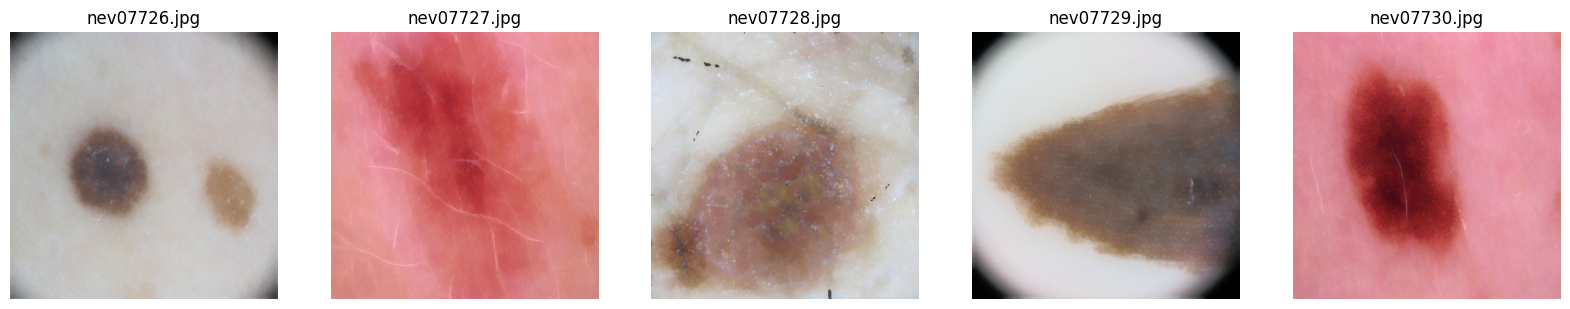

In [44]:
# hair removal
test_images_hair_removal = [hair_removal(image) for image in test_images[0:5]]
visualise_images(test_images_hair_removal[:5], test_labels[0:5])

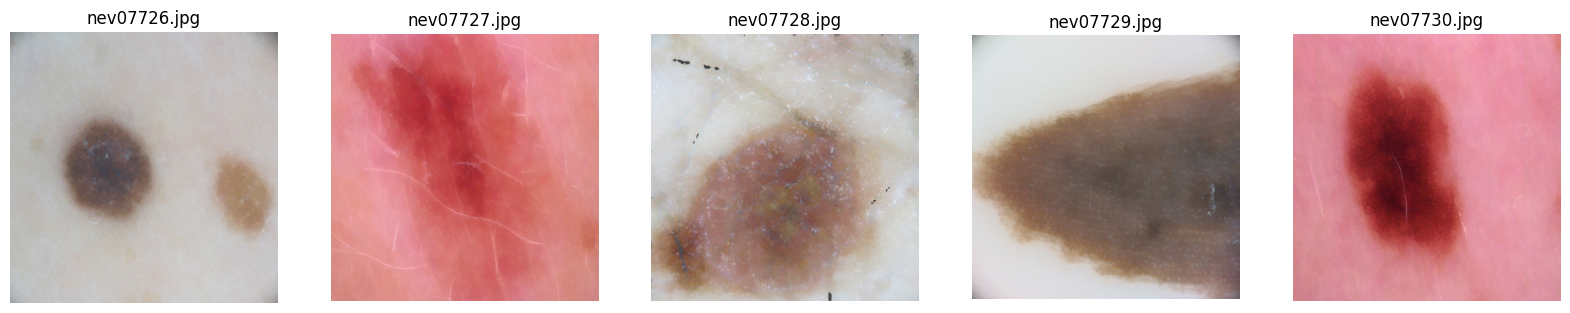

In [45]:
cropped_images = [crop_img(image) for image in test_images_hair_removal[:5]]
visualise_images(cropped_images, test_labels[:5])

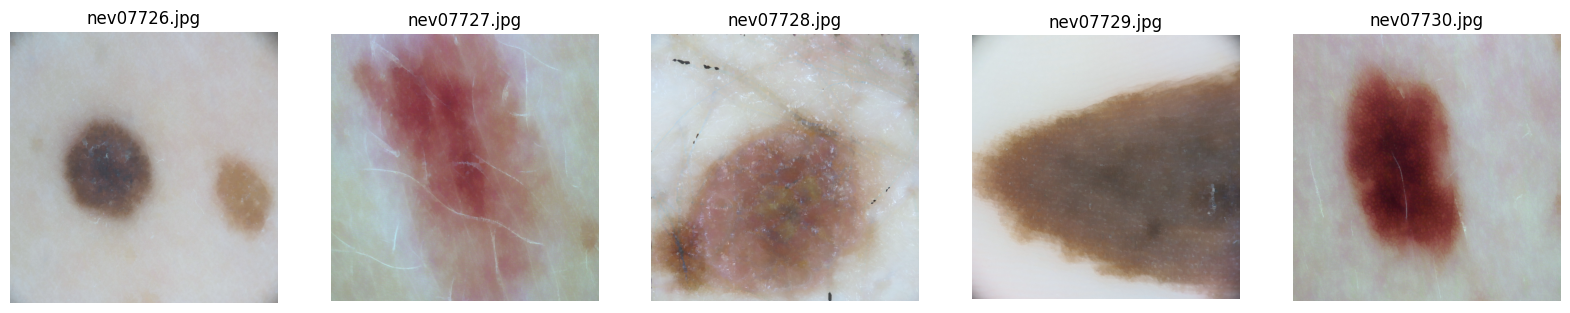

In [46]:
norm_images = [normalize_colors_shades_of_gray(image) for image in cropped_images]
visualise_images(norm_images, test_labels[:5])

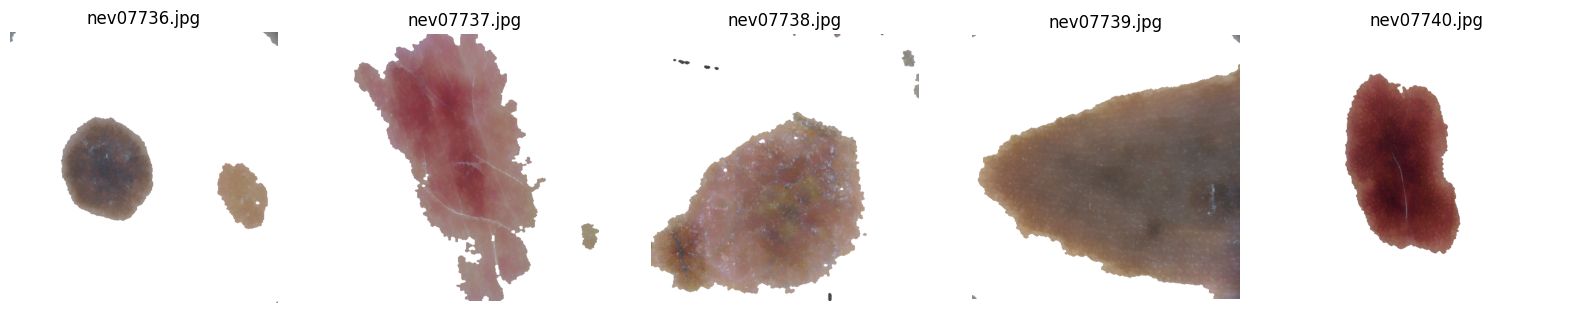

In [47]:
# enhance structures
test_images_enhanced = [enhance_structures(image) for image in norm_images]
visualise_images(test_images_enhanced[:5], test_labels[10:15])

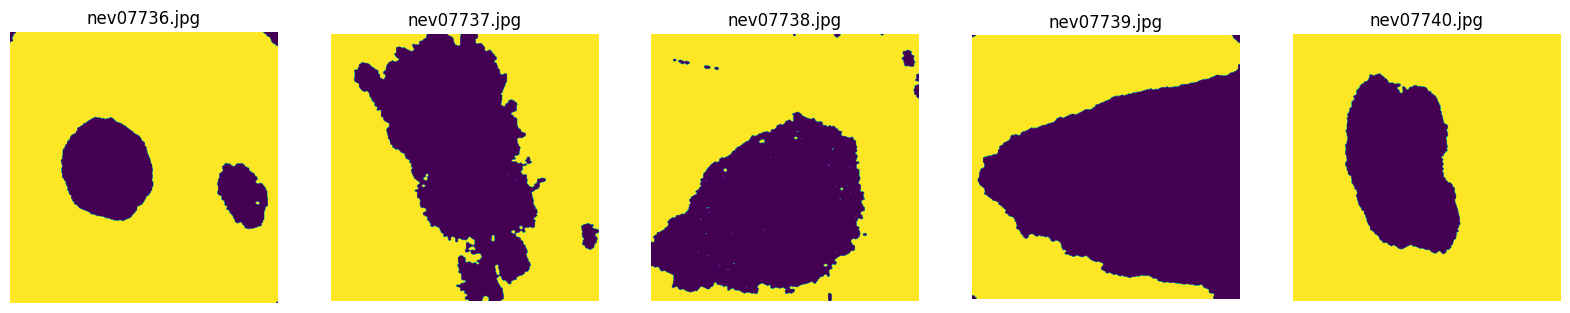

In [48]:
masks = [binarize_and_make_mask(image) for image in test_images_enhanced[:5]]
visualise_images(masks, test_labels[10:15])

In [4]:
# # save pre-processed images in appropriate folders
# for image_path in TRAIN_IMAGES_PATH:
#     directory = '/'.join(image_path.replace("\\", "/").split('/')[-2:])
#     save_path = os.path.join('../../dataset/preprocessed_train', directory)
#     if os.path.exists(save_path):
#         continue
#     else:
#         image = cv2.imread(image_path)
#         image = cv2.cvtColor(image, cv2.IMREAD_COLOR)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         # image = cv2.resize(image, (500, 500))
#         hair_removed = hair_removal(image)
#         cropped_image = crop_img(hair_removed)
#         norm_image = normalize_colors_shades_of_gray(cropped_image)
#         pil_image = Image.fromarray(norm_image)
#         pil_image.save(save_path)


In [5]:
# # save pre-processed images in appropriate folders
# for image_path in VAL_IMAGES_PATH:
#     directory = '/'.join(image_path.replace("\\", "/").split('/')[-2:])
#     save_path = os.path.join('../../dataset/preprocessed_val', directory)
#     if os.path.exists(save_path):
#         continue
#     else:
#         image = cv2.imread(image_path)
#         image = cv2.cvtColor(image, cv2.IMREAD_COLOR)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         # image = cv2.resize(image, (500, 500))
#         hair_removed = hair_removal(image)
#         cropped_image = crop_img(hair_removed)
#         norm_image = normalize_colors_shades_of_gray(cropped_image)
#         pil_image = Image.fromarray(norm_image)
#         pil_image.save(save_path)

## Feature Extraction

1. Color Moments: Mean, Std, Variance, Skewness, 
2. Color Hist in *HSV, LAB, RGB
3. Texture: LBP and GLCM


In [3]:
# # Load the preprocessed images
PREPROCESSED_TRAIN_IMAGES_PATH =  sorted(glob.glob(os.path.join('../../dataset/preprocessed_train/*', "*.jpg")))
PREPROCESSED_VAL_IMAGES_PATH =  sorted(glob.glob(os.path.join('../../dataset/preprocessed_val/*', "*.jpg")))
print(f"Number of training images: {len(PREPROCESSED_TRAIN_IMAGES_PATH)}")
print(f"Number of validation images: {len(PREPROCESSED_VAL_IMAGES_PATH)}")

Number of training images: 15195
Number of validation images: 3796


In [4]:
# Load the image labels
train_labels = [image_path.split('\\')[-2] for image_path in PREPROCESSED_TRAIN_IMAGES_PATH]
val_labels = [image_path.split('\\')[-2] for image_path in PREPROCESSED_VAL_IMAGES_PATH]
print(f"Number of training labels: {len(train_labels)}")
print(f"Number of validation labels: {len(val_labels)}")

# labels encoding
le = preprocessing.LabelEncoder()
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)
val_labels_encoded = le.transform(val_labels)

Number of training labels: 15195
Number of validation labels: 3796


In [14]:
# compute the training features
color_moments_train_features = []
color_histogram_train_features = []

for image_path in PREPROCESSED_TRAIN_IMAGES_PATH:
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (500, 500), interpolation=cv2.INTER_CUBIC)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # image = enhance_structures(image)
    moments = color_moments(image)
    histogram = extract_color_histogram(image)
    color_moments_train_features.append(moments)
    color_histogram_train_features.append(histogram)
color_moments_train_features = np.array(color_moments_train_features).reshape((15195, 12))
color_histogram_train_features = np.array(color_histogram_train_features).reshape((15195, 2304))

lbp_train_image_features = []
glcm_train_image_features = []

for image_path in PREPROCESSED_TRAIN_IMAGES_PATH:
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (500, 500), interpolation=cv2.INTER_CUBIC)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp_5_8 = lbp_feature_extractor(image, radius=5, points=8)
    lbp_5_16 = lbp_feature_extractor(image, radius=5, points=16)
    lbb_10_8 = lbp_feature_extractor(image, radius=10, points=8)
    lbp_10_16 = lbp_feature_extractor(image, radius=10, points=16)
    glcm = glcm_feature_extractor(image)
    lbp_train_image_features.append(np.hstack((lbp_5_8, lbp_5_16, lbb_10_8, lbp_10_16)))
    glcm_train_image_features.append(glcm)
lbp_train_image_features = np.array(lbp_train_image_features)
glcm_train_image_features = np.array(glcm_train_image_features).reshape((15195, 25))   

In [13]:
# compute the validation features
color_moments_val_features = []
color_histogram_val_features = []

for image_path in PREPROCESSED_VAL_IMAGES_PATH:
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (500, 500), interpolation=cv2.INTER_CUBIC)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # image = enhance_structures(image)
    moments = color_moments(image)
    histogram = extract_color_histogram(image)
    color_moments_val_features.append(moments)
    color_histogram_val_features.append(histogram)
color_moments_val_features = np.array(color_moments_val_features).reshape((3796, 12))
color_histogram_val_features = np.array(color_histogram_val_features).reshape((3796, 2304))


lbp_val_image_features = []
glcm_val_image_features = []

for image_path in PREPROCESSED_VAL_IMAGES_PATH:
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (500, 500), interpolation=cv2.INTER_CUBIC)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp_5_8 = lbp_feature_extractor(image, radius=5, points=8)
    lbp_5_16 = lbp_feature_extractor(image, radius=5, points=16)
    lbb_10_8 = lbp_feature_extractor(image, radius=10, points=8)
    lbp_10_16 = lbp_feature_extractor(image, radius=10, points=16)
    glcm = glcm_feature_extractor(image)
    lbp_val_image_features.append(np.hstack((lbp_5_8, lbp_5_16, lbb_10_8, lbp_10_16)))
    glcm_val_image_features.append(glcm)
lbp_val_image_features = np.array(lbp_val_image_features)
glcm_val_image_features = np.array(glcm_val_image_features).reshape((3796, 25))

In [10]:
print(f"Train labels shape: {train_labels_encoded.shape}")
print(f"GLCM Train features shape: {glcm_train_image_features.shape}")
print(f"LBP Train features shape: {lbp_train_image_features.shape}")
print(f"Color Moments Train features shape: {color_moments_train_features.shape}")
print(f"Color Histogram Train features shape: {color_histogram_train_features.shape}")

print(f"GLCM Validation features shape: {glcm_val_image_features.shape}")
print(f"LBP Validation features shape: {lbp_val_image_features.shape}")
print(f"Color Moments Validation features shape: {color_moments_val_features.shape}")
print(f"Color Histogram Validation features shape: {color_histogram_val_features.shape}")

In [5]:
# concatenate all features
# all_train_features = np.hstack((glcm_train_image_features, lbp_train_image_features, color_moments_train_features, color_histogram_train_features))
# all_val_features = np.hstack((glcm_val_image_features, lbp_val_image_features, color_moments_val_features, color_histogram_val_features))

# save all features
# np.save('../../dataset/preprocessed_train/all_train_features.npy', all_train_features)
# np.save('../../dataset/preprocessed_val/all_test_features.npy', all_val_features)

# load all features
all_train_features = np.load('../../dataset/preprocessed_train/all_train_features.npy')
all_val_features = np.load('../../dataset/preprocessed_val/all_test_features.npy')

print(f"All Train features shape: {all_train_features.shape}")
print(f"All Validation features shape: {all_val_features.shape}")
# first 25 features are GLCM features, next 56 features are LBP features, next 12 features are color moments, and the last 2304 features are color histogram features

All Train features shape: (15195, 2397)
All Validation features shape: (3796, 2397)


# EDA

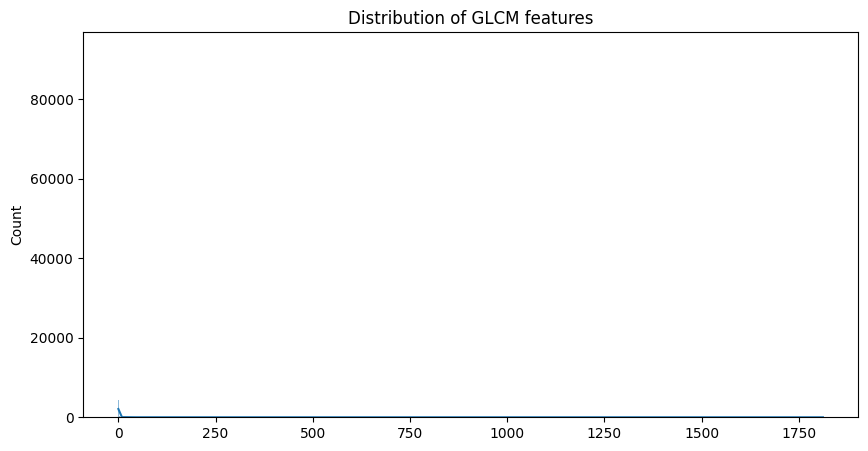

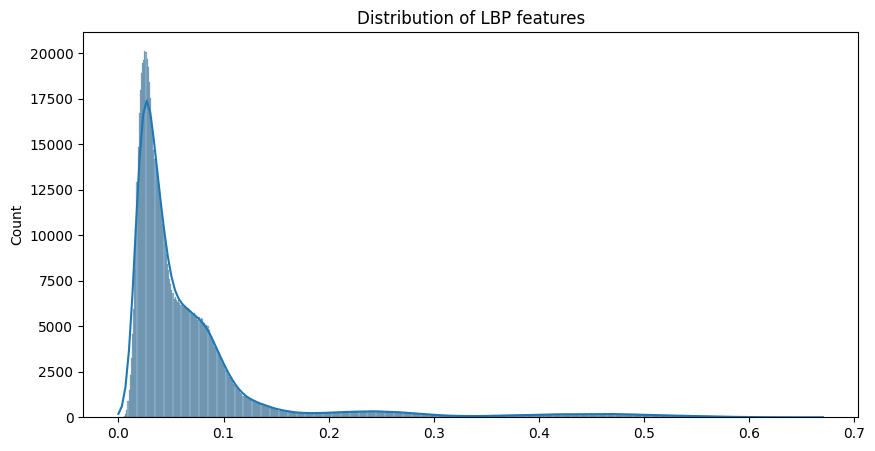

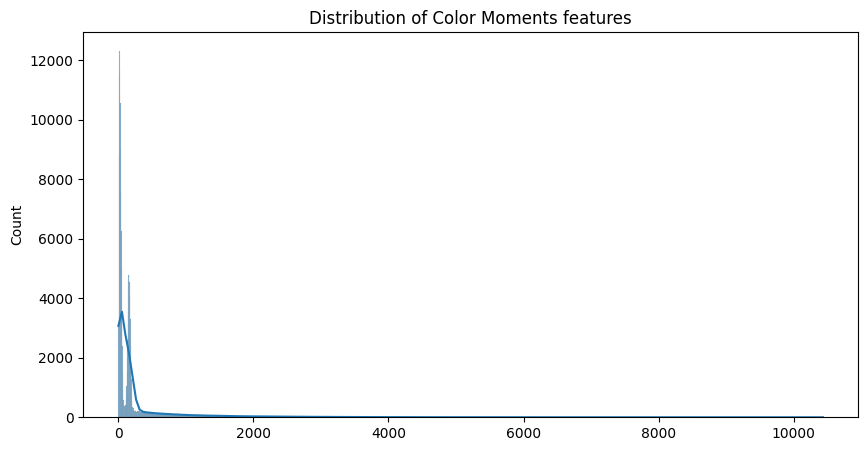

In [9]:
# plot the distribution of the first 25 features
plt.figure(figsize=(10, 5))
sns.histplot(all_train_features[:, :25].flatten(), kde=True)
plt.title("Distribution of GLCM features")
plt.show()

# plot the distribution of the next 56 features
plt.figure(figsize=(10, 5))
sns.histplot(all_train_features[:, 25:81].flatten(), kde=True)
plt.title("Distribution of LBP features")
plt.show()

# plot the distribution of the next 12 features
plt.figure(figsize=(10, 5))
sns.histplot(all_train_features[:, 81:93].flatten(), kde=True)
plt.title("Distribution of Color Moments features")
plt.show()

# Model Training

In [6]:
X_train, Y_train, x_val, y_val = all_train_features, train_labels_encoded, all_val_features, val_labels_encoded
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

In [7]:
# apply log transformation to the features
x_val_l = np.log1p(x_val)
X_train_l = np.log1p(X_train)

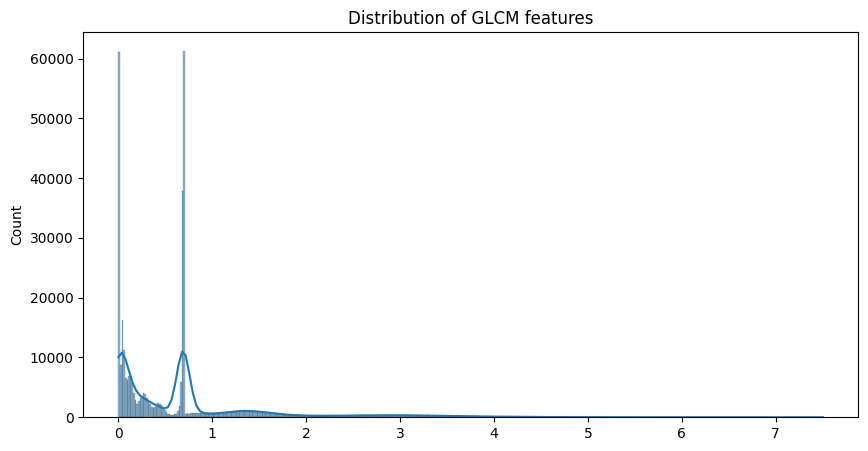

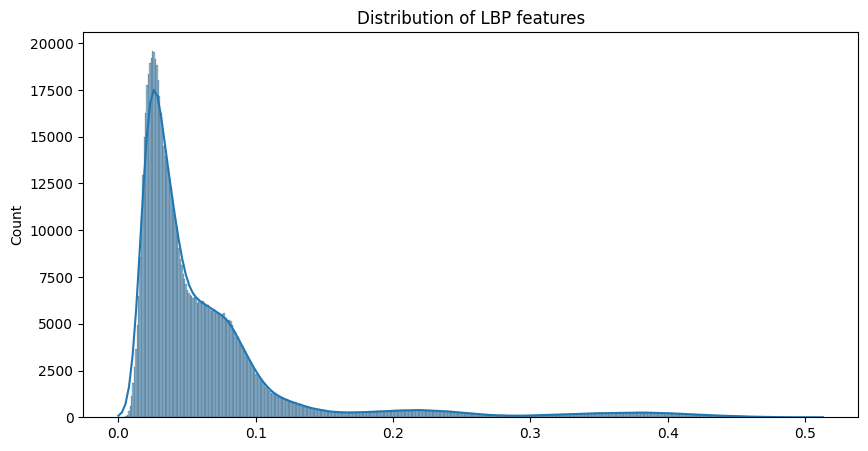

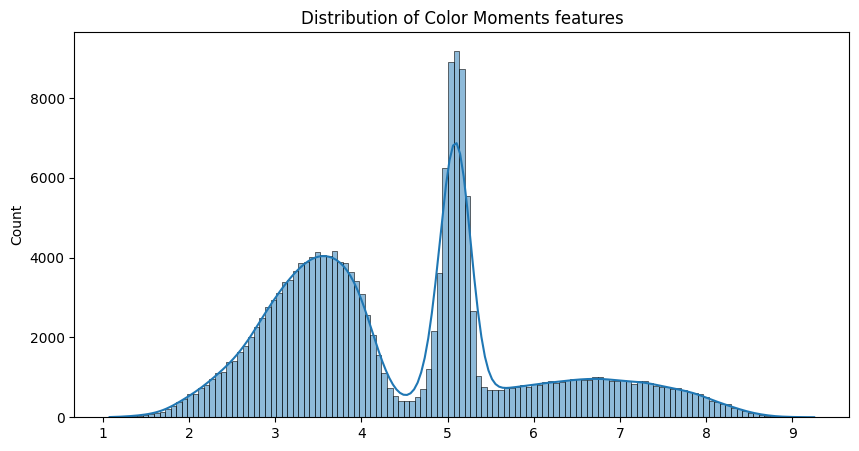

In [8]:
# plot the distribution of the first 25 features
plt.figure(figsize=(10, 5))
sns.histplot(X_train_l[:, :25].flatten(), kde=True)
plt.title("Distribution of GLCM features")
plt.show()

# plot the distribution of the next 56 features
plt.figure(figsize=(10, 5))
sns.histplot(X_train_l[:, 25:81].flatten(), kde=True)
plt.title("Distribution of LBP features")
plt.show()

# plot the distribution of the next 12 features
plt.figure(figsize=(10, 5))
sns.histplot(X_train_l[:, 81:93].flatten(), kde=True)
plt.title("Distribution of Color Moments features")
plt.show()

In [9]:
# apply min-max scaling to the features
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
x_val_s = scaler.transform(x_val_l)
X_train_s = scaler.transform(X_train_l)

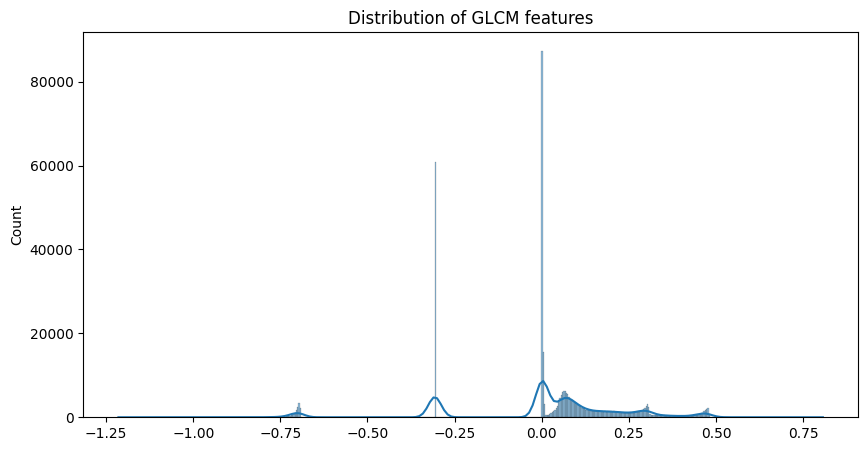

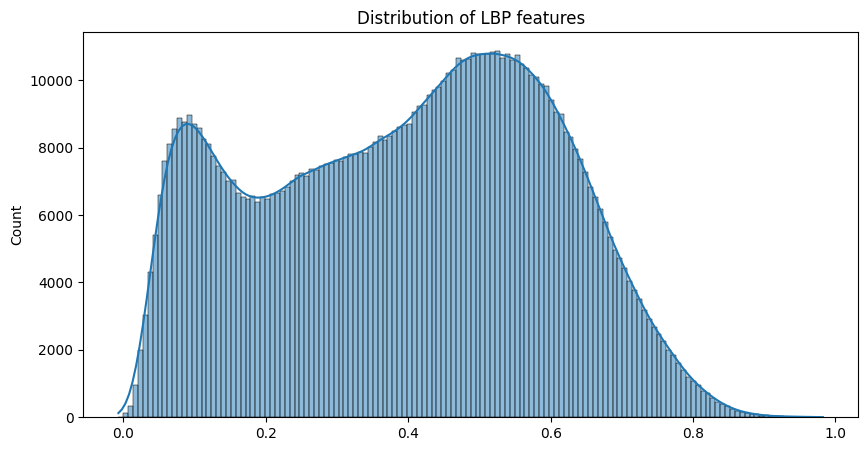

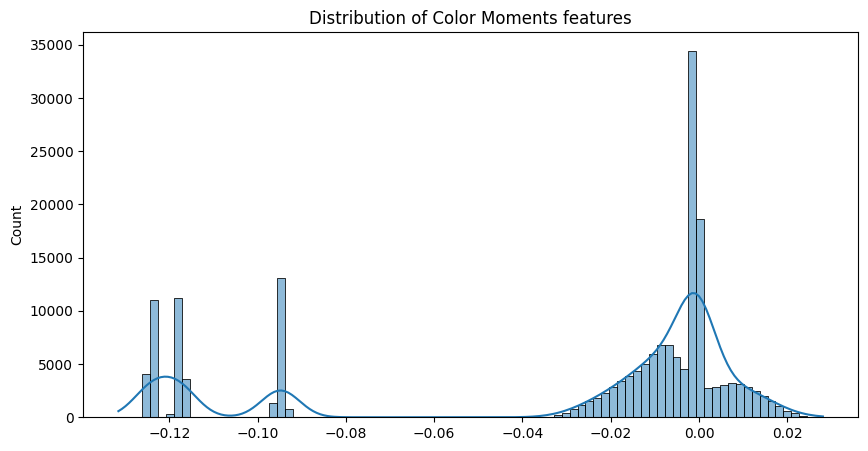

In [10]:
# plot the distribution of the first 25 features
plt.figure(figsize=(10, 5))
sns.histplot(X_train_s[:, :25].flatten(), kde=True)
plt.title("Distribution of GLCM features")
plt.show()

# plot the distribution of the next 56 features
plt.figure(figsize=(10, 5))
sns.histplot(X_train_s[:, 25:81].flatten(), kde=True)
plt.title("Distribution of LBP features")
plt.show()

# plot the distribution of the next 12 features
plt.figure(figsize=(10, 5))
sns.histplot(X_train_s[:, 81:93].flatten(), kde=True)
plt.title("Distribution of Color Moments features")
plt.show()

In [11]:
print("Train data shape: ", x_train.shape)
print("Train labels shape: ", y_train.shape)
print("Test data shape: ", x_test.shape)
print("Test labels shape: ", y_test.shape)
print("Validation data shape: ", x_val.shape)
print("Validation labels shape: ", y_val.shape)

Train data shape:  (12156, 2397)
Train labels shape:  (12156,)
Test data shape:  (3039, 2397)
Test labels shape:  (3039,)
Validation data shape:  (3796, 2397)
Validation labels shape:  (3796,)


## Model Training and Selection

In [12]:
model_list = [RandomForestClassifier(random_state=42), KNeighborsClassifier(), XGBClassifier(), lgb.LGBMClassifier(verbose=-1),
              SVC(random_state=42), CatBoostClassifier(logging_level='Silent')]
model_names = ['Random Forest', 'KNN', 'XGBoost', 'LightGBM', 'SVM', 'CatBoost']

random_foreset_params = {'n_estimators': [50, 100, 200, 300], 'max_depth': [10, 20, 30, 40, 50]}
svc_params = {'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf']}
knn_params = {'n_neighbors': [3, 5, 7, 9, 11], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}
xgb_params = {'n_estimators': [50, 100, 200, 300], 'max_depth': [10, 20, 30, 40, 50]}
lgbm_params = {'learning_rate': [0.05, 0.1, 0.2], 'boosting_type': ['gbdt', 'dart'], 'num_leaves': [31, 50, 100]}
catboost_params = {'iterations': [50, 100, 200, 300], 'depth': [4, 6, 8, 10]}

In [14]:
for model, model_name in zip(model_list, model_names):
    if model_name == 'Random Forest':
        param_grid = random_foreset_params
    elif model_name == 'SVM':
        param_grid = svc_params
    if model_name == 'KNN':
        param_grid = knn_params
    elif model_name == 'XGBoost':
        param_grid = xgb_params
    elif model_name == 'LightGBM':
        param_grid = lgbm_params
    elif model_name == 'CatBoost':
        param_grid = catboost_params
    else:
        continue
    print("Hyperparameter tuning for {}".format(model_name))
    print("==============================================================================================")
    grid_search = GridSearchCV(model, param_grid, cv=2)
    grid_search.fit(x_train, y_train)
    best_params = grid_search.best_params_
    print("Best Parameters for {}: {}".format(model_name, best_params))
    model = model.set_params(**best_params)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    y_val_pred = model.predict(x_val)
    test_accuracy = metrics.accuracy_score(y_test, y_pred)
    val_accuracy = metrics.accuracy_score(y_val, y_val_pred)
    print("Validation Accuracy for {}: {:.3f}".format(model_name, val_accuracy))
    print("Test Accuracy for {}: {:.3f}".format(model_name, test_accuracy))
    print("==============================================================================================")
    # save the model
    model_path = os.path.join('../../', model_name + '.pkl')
    joblib.dump(model, model_path)

Hyperparameter tuning for KNN
Best Parameters for KNN: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
Validation Accuracy for KNN: 0.692
Test Accuracy for KNN: 0.669
Hyperparameter tuning for XGBoost
Best Parameters for XGBoost: {'max_depth': 30, 'n_estimators': 200}
Validation Accuracy for XGBoost: 0.833
Test Accuracy for XGBoost: 0.826
Hyperparameter tuning for LightGBM
Best Parameters for LightGBM: {'boosting_type': 'gbdt', 'learning_rate': 0.2, 'num_leaves': 50}
Validation Accuracy for LightGBM: 0.833
Test Accuracy for LightGBM: 0.822
Hyperparameter tuning for CatBoost
Best Parameters for CatBoost: {'depth': 10, 'iterations': 300}
Validation Accuracy for CatBoost: 0.825
Test Accuracy for CatBoost: 0.826


## Model Report for Each Classifier

In [12]:
knn_model = KNeighborsClassifier(metric='manhattan', n_neighbors=9, weights='distance')
knn_model.fit(X_train, Y_train)

# save the model
# model_path = os.path.join('./', 'KNN.pkl')
# joblib.dump(knn_model, model_path)

# Predict on the test data
val_prediction = knn_model.predict(x_val)
# Inverse le transform to get original label back. 
val_prediction_transformed = le.inverse_transform(val_prediction)

print("Classification report")
print(metrics.classification_report(val_labels, val_prediction_transformed))

Classification report
              precision    recall  f1-score   support

       nevus       0.70      0.71      0.71      1931
      others       0.70      0.69      0.69      1865

    accuracy                           0.70      3796
   macro avg       0.70      0.70      0.70      3796
weighted avg       0.70      0.70      0.70      3796



In [13]:
xgb_model = XGBClassifier(max_depth=50, n_estimators=200)
xgb_model.fit(X_train, Y_train)

# save the model
# model_path = os.path.join('./', 'XGB.pkl')
# joblib.dump(xgb_model, model_path)

# Predict on the test data
val_prediction = xgb_model.predict(x_val)
# Inverse le transform to get original label back. 
val_prediction_transformed = le.inverse_transform(val_prediction)

print("Classification report")
print(metrics.classification_report(val_labels, val_prediction_transformed))

Classification report
              precision    recall  f1-score   support

       nevus       0.83      0.86      0.84      1931
      others       0.85      0.82      0.83      1865

    accuracy                           0.84      3796
   macro avg       0.84      0.84      0.84      3796
weighted avg       0.84      0.84      0.84      3796



In [14]:
# lightgbm model
lgbm_model = lgb.LGBMClassifier(boosting_type='gbdt', learning_rate=0.2, num_leaves=50, verbose=-1)
lgbm_model.fit(X_train, Y_train)

# save the model
# model_path = os.path.join('./', 'LightGBM.pkl')
# joblib.dump(lgbm_model, model_path)

# Predict on the test data
val_prediction = lgbm_model.predict(x_val)
# Inverse le transform to get original label back.
val_prediction_transformed = le.inverse_transform(val_prediction)

print("Classification report")
print(metrics.classification_report(val_labels, val_prediction_transformed))

Classification report
              precision    recall  f1-score   support

       nevus       0.82      0.85      0.84      1931
      others       0.84      0.81      0.83      1865

    accuracy                           0.83      3796
   macro avg       0.83      0.83      0.83      3796
weighted avg       0.83      0.83      0.83      3796



In [15]:
svm_model = SVC(random_state=42, C=10, gamma=0.1, kernel='rbf')
svm_model.fit(X_train, Y_train)

# save the model
# model_path = os.path.join('./', 'SVM.pkl')
# joblib.dump(svm_model, model_path)

# Predict on the test data
val_prediction = svm_model.predict(x_val)
# Inverse le transform to get original label back. 
val_prediction_transformed = le.inverse_transform(val_prediction)

print("Classification report")
print(metrics.classification_report(val_labels, val_prediction_transformed))

Classification report
              precision    recall  f1-score   support

       nevus       0.51      1.00      0.68      1931
      others       1.00      0.01      0.02      1865

    accuracy                           0.51      3796
   macro avg       0.76      0.50      0.35      3796
weighted avg       0.75      0.51      0.35      3796



In [16]:
catboost_model = CatBoostClassifier(depth=10, iterations=300, logging_level='Silent')
catboost_model.fit(X_train, Y_train)

# save the model
# model_path = os.path.join('./', 'Catboost.pkl')
# joblib.dump(catboost_model, model_path)


# Predict on the test data
val_prediction = catboost_model.predict(x_val)
# Inverse le transform to get original label back. 
val_prediction_transformed = le.inverse_transform(val_prediction)

print("Classification report")
print(metrics.classification_report(val_labels, val_prediction_transformed))

Classification report
              precision    recall  f1-score   support

       nevus       0.82      0.85      0.84      1931
      others       0.84      0.81      0.83      1865

    accuracy                           0.83      3796
   macro avg       0.83      0.83      0.83      3796
weighted avg       0.83      0.83      0.83      3796



In [12]:
random_foreset_model = RandomForestClassifier(max_depth=20, n_estimators=300, random_state=42)
random_foreset_model.fit(X_train, Y_train)

# save the model
# model_path = os.path.join('./', 'RandomForest.pkl')
# joblib.dump(random_foreset_model, model_path)

# Predict on the test data
val_prediction = random_foreset_model.predict(x_val)
# Inverse le transform to get original label back. 
val_prediction_transformed = le.inverse_transform(val_prediction)

print("Classification report")
print(metrics.classification_report(val_labels, val_prediction_transformed))

Classification report
              precision    recall  f1-score   support

       nevus       0.81      0.86      0.83      1931
      others       0.84      0.79      0.82      1865

    accuracy                           0.83      3796
   macro avg       0.83      0.83      0.83      3796
weighted avg       0.83      0.83      0.83      3796



## Best Model Retraining

In [18]:
xgb_model = XGBClassifier(max_depth=30, n_estimators=200)
xgb_model.fit(X_train, Y_train)

# Predict on test
val_prediction = xgb_model.predict(x_val)
# Inverse le transform to get original label back. 
val_prediction_transformed = le.inverse_transform(val_prediction)

Feature: 0, Score: 0.00051
Feature: 1, Score: 0.00041
Feature: 2, Score: 0.00047
Feature: 3, Score: 0.00044
Feature: 4, Score: 0.00044
Feature: 5, Score: 0.00058
Feature: 6, Score: 0.00049
Feature: 7, Score: 0.00071
Feature: 8, Score: 0.00064
Feature: 9, Score: 0.00033
Feature: 10, Score: 0.00006
Feature: 11, Score: 0.00066
Feature: 12, Score: 0.00051
Feature: 13, Score: 0.00035
Feature: 14, Score: 0.00097
Feature: 15, Score: 0.00055
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00073
Feature: 26, Score: 0.00061
Feature: 27, Score: 0.00033
Feature: 28, Score: 0.00081
Feature: 29, Score: 0.00049
Feature: 30, Score: 0.00079
Feature: 31, Score: 0.00053
Feature: 32, Score: 0.00063
Feature: 33, Score: 0.00105
Feature: 34, Score: 0.00083
Feature: 35, Score: 0.00030
Fe

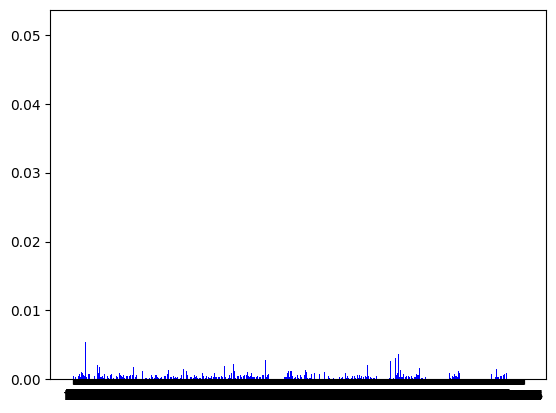

In [19]:
# get the feature importance
feature_importance = xgb_model.feature_importances_
# summarize feature importance
for i,v in enumerate(feature_importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(feature_importance))], feature_importance, tick_label=[f'f{i}' for i in range(len(feature_importance))], color='blue')
plt.show()

## Best Model Metrics

Classification report
              precision    recall  f1-score   support

       nevus       0.83      0.85      0.84      1931
      others       0.84      0.82      0.83      1865

    accuracy                           0.84      3796
   macro avg       0.84      0.84      0.84      3796
weighted avg       0.84      0.84      0.84      3796

Confusion Matrix


<Axes: >

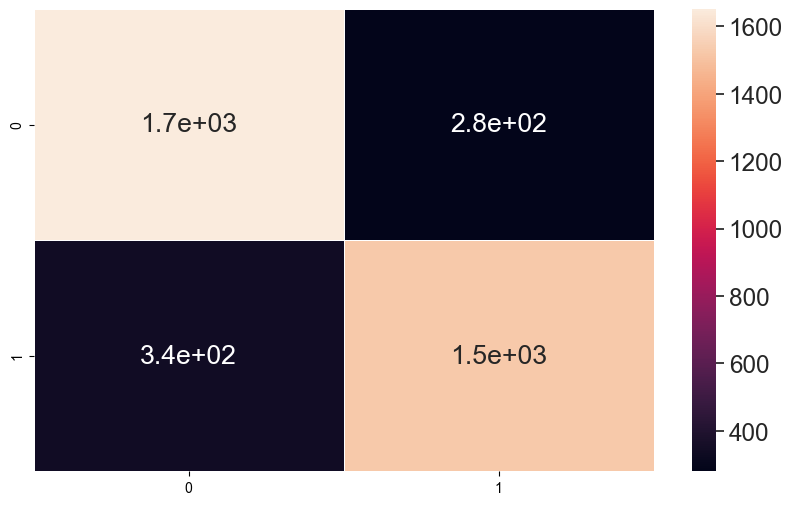

In [20]:
print("Classification report")
print(metrics.classification_report(val_labels, val_prediction_transformed))

print("Confusion Matrix")
# Print confusion matrix
cm = confusion_matrix(val_labels, val_prediction_transformed)

fig, ax = plt.subplots(figsize=(10,6))  
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

In [21]:
# Get predicted probabilities
y_probs = xgb_model.predict_proba(x_val)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_val, y_probs)

# Compute AUC
roc_auc = metrics.auc(fpr, tpr)

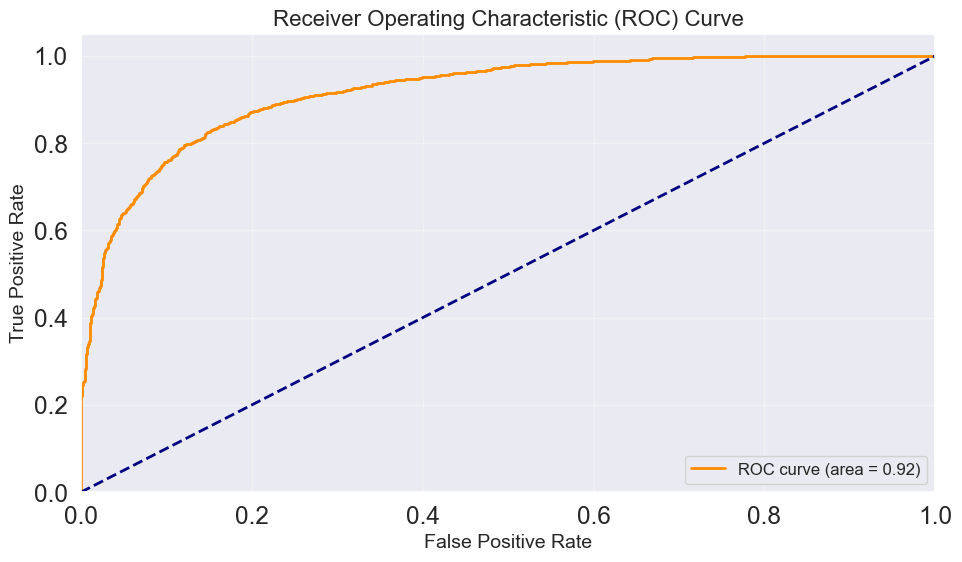

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Ensemble Of Best Models

[LightGBM] [Info] Number of positive: 7470, number of negative: 7725
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.243253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 483625
[LightGBM] [Info] Number of data points in the train set: 15195, number of used features: 2008
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.491609 -> initscore=-0.033567
[LightGBM] [Info] Start training from score -0.033567
Accuracy =  0.8382507903055848
Classification report
              precision    recall  f1-score   support

       nevus       0.83      0.86      0.84      1931
      others       0.85      0.81      0.83      1865

    accuracy                           0.84      3796
   macro avg       0.84      0.84      0.84      3796
weighted avg       0.84      0.84      0.84      3796

Precision Score: 0.8388499643355232
Recall Score: 0.8382507903055848
F1 Score: 0.8380984171283921
Kaapa Val Score: 0.6761426

<Axes: >

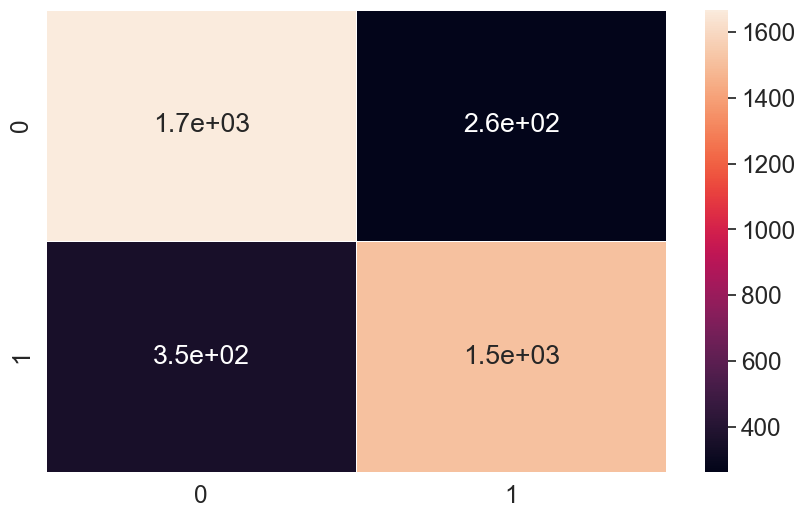

In [11]:
# make ensemble of classifiers
lgbm_model = lgb.LGBMClassifier(boosting_type='gbdt', learning_rate=0.2, num_leaves=50, random_state=42, verbose=-1)
xgb_model = XGBClassifier(max_depth=30, n_estimators=200, random_state=42)
random_foreset_model = RandomForestClassifier(max_depth=20, n_estimators=300, random_state=42)
ensemble_soft = VotingClassifier(estimators=[('rf', random_foreset_model), ('xgb', xgb_model), ('lgbm', lgbm_model)], voting='soft')
ensemble_soft.fit(X_train, Y_train)

# save the model
model_path = os.path.join('./', 'Ensemble_soft.pkl')
joblib.dump(ensemble_soft, model_path)

# Predict on test
val_prediction = ensemble_soft.predict(x_val)
# Inverse le transform to get original label back. 
val_prediction_transformed = le.inverse_transform(val_prediction)

print("Classification report")
print(metrics.classification_report(val_labels, val_prediction_transformed))

print("Confusion Matrix")
# Print confusion matrix
cm = confusion_matrix(val_labels, val_prediction_transformed)
fig, ax = plt.subplots(figsize=(10, 6))  
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

[LightGBM] [Info] Number of positive: 7470, number of negative: 7725
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.327852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 483625
[LightGBM] [Info] Number of data points in the train set: 15195, number of used features: 2008
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.491609 -> initscore=-0.033567
[LightGBM] [Info] Start training from score -0.033567
Accuracy =  0.8366701791359326
Classification report
              precision    recall  f1-score   support

       nevus       0.83      0.86      0.84      1931
      others       0.85      0.82      0.83      1865

    accuracy                           0.84      3796
   macro avg       0.84      0.84      0.84      3796
weighted avg       0.84      0.84      0.84      3796

Precision Score: 0.8369793708140763
Recall Score: 0.8366701791359326
F1 Score: 0.8365713109858018
Kaapa Val Score: 0.6730438

<Axes: >

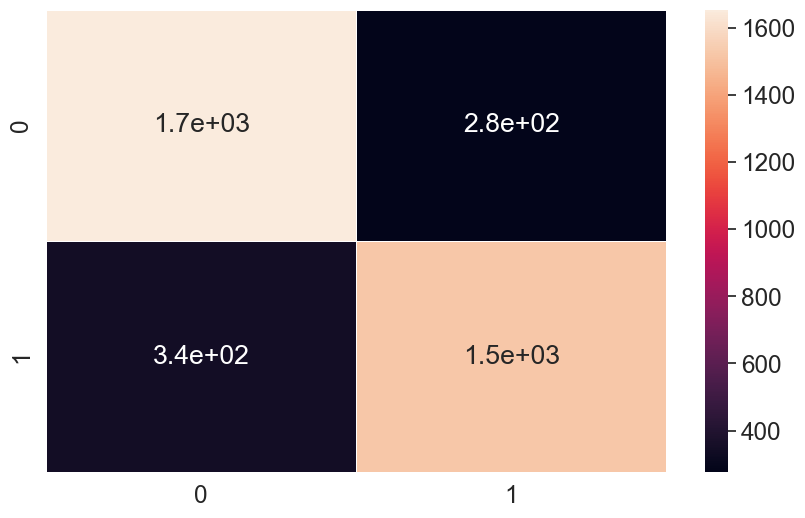

In [12]:
grad_boost = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, random_state=42)
ada_boost = AdaBoostClassifier(n_estimators=100, random_state=42)
xgb_model = XGBClassifier(max_depth=30, n_estimators=200, random_state=42)
lgbm_model = lgb.LGBMClassifier(boosting_type='gbdt', learning_rate=0.2, num_leaves=50, random_state=42, verbose=-1)
random_foreset_model = RandomForestClassifier(max_depth=20, n_estimators=300, random_state=42)
ensemble_soft = VotingClassifier(estimators=[('rf', random_foreset_model), ('xgb', xgb_model), ('lgbm', lgbm_model), ('grad_boost', grad_boost), ('ada_boost', ada_boost)], voting='soft')
ensemble_soft.fit(X_train, Y_train)

# Predict on test
val_prediction = ensemble_soft.predict(x_val)
# Inverse le transform to get original label back. 
val_prediction_transformed = le.inverse_transform(val_prediction)

print("Classification report")
print(metrics.classification_report(val_labels, val_prediction_transformed))

print("Confusion Matrix")
# Print confusion matrix
cm = confusion_matrix(val_labels, val_prediction_transformed)
fig, ax = plt.subplots(figsize=(10, 6))  
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

# Predictions

In [23]:
# stack X_train and X_val to train the final model
X_train_val = np.vstack((X_train, x_val))
Y_train_val = np.hstack((Y_train, y_val))

# train the final model
xgb_model_f = XGBClassifier(max_depth=30, n_estimators=200, random_state=42)
xgb_model_f.fit(X_train_val, Y_train_val)

# save the model
model_path = os.path.join('./', 'Final_xgb_model.pkl')
joblib.dump(xgb_model_f, model_path)

['./Final_xgb_model.pkl']

In [24]:
TEST_IMAGES_PATH =  sorted(glob.glob(os.path.join('../../dataset/testX', "*.jpg")))
print(f"Number of test images: {len(TEST_IMAGES_PATH)}")

Number of test images: 6340


In [5]:
# compute the test features
color_moments_test_features = []
color_histogram_test_features = []
lbp_test_image_features = []
glcm_test_image_features = []

for image_path in TEST_IMAGES_PATH:
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    hair_removed = hair_removal(image)
    cropped_image = crop_img(hair_removed)
    norm_image = normalize_colors_shades_of_gray(cropped_image)
    image = cv2.resize(norm_image, (500, 500), interpolation=cv2.INTER_CUBIC)

    
    moments = color_moments(image)
    histogram = extract_color_histogram(image)
    color_moments_test_features.append(moments)
    color_histogram_test_features.append(histogram)
        
        
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    lbp_5_8 = lbp_feature_extractor(image_gray, radius=5, points=8)
    lbp_5_16 = lbp_feature_extractor(image_gray, radius=5, points=16)
    lbb_10_8 = lbp_feature_extractor(image_gray, radius=10, points=8)
    lbp_10_16 = lbp_feature_extractor(image_gray, radius=10, points=16)
    glcm = glcm_feature_extractor(image_gray)
    
    lbp_test_image_features.append(np.hstack((lbp_5_8, lbp_5_16, lbb_10_8, lbp_10_16)))
    glcm_test_image_features.append(glcm)

lbp_test_image_features = np.array(lbp_test_image_features)
glcm_test_image_features = np.array(glcm_test_image_features).reshape((6340, 25))   
color_moments_test_features = np.array(color_moments_test_features).reshape((6340, 12))
color_histogram_test_features = np.array(color_histogram_test_features).reshape((6340, 2304))

# Combine all features
all_test_features = np.hstack((glcm_test_image_features, lbp_test_image_features, color_moments_test_features, color_histogram_test_features))

# save all features
np.save('../../dataset/testX/all_test_features.npy', all_test_features)

In [26]:
# load all features
all_test_features = np.load('../../dataset/testX/all_test_features.npy')
# Make predictions
predictions = xgb_model_f.predict(all_test_features)
output_file = 'ML_binary_preds.txt'

# Save predictions to a text file
with open(output_file, 'w') as f:
    for i, pred in enumerate(predictions):
        f.write(f"{os.path.basename(TEST_IMAGES_PATH[i])}: {pred}\n")

print(f"Predictions saved to {output_file}")

Predictions saved to ML_binary_preds_sub.txt


In [1]:
import pandas as pd

# Load the text file
file_path = r"ML_binary_preds.txt"
with open(file_path, 'r') as file:
    lines = file.readlines()

# Parse the lines into a DataFrame
data = []
for line in lines:
    img_name, label = line.strip().split(': ')
    data.append((img_name, int(label)))

# Convert to DataFrame and save as CSV
df = pd.DataFrame(data, columns=['Image', 'Prediction'])
csv_path = "ML_binary_preds.csv"
df.to_csv(csv_path, index=False)

csv_path


'ML_binary_preds.csv'